# 6.6 Sourcing & Analyzing Time Series Data

# Contents

### 01. Importing libraries and data
### 02. Subsetting, wrangling and cleating time-series data
### 03. Time-series analysis decomposition
### 04. Testing for stationarity
### 05. Stationarizing the Federal Reserve Economic Data


## 01. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Configure API key
quandl.ApiConfig.api_key = 'TeLbSv_mfZf-EPSDxrNS'

In [4]:
# Harmonized Index of Consumer Prices: Actual Rentals for Housing for Germany from 1996-2016
# Note - I attempted to find a Real Estate data set relevant to my project and I tried using my data from my dataset but
# I nearly lost my mind 

data = quandl.get('FRED/CP0410DEM086NEST')

In [5]:
data.shape

(249, 1)

In [6]:
data.head()

,VALUE
DATE,
1996-01-01,78.6
1996-02-01,78.8
1996-03-01,79.0
1996-04-01,79.0
1996-05-01,79.2


In [7]:
data.columns

Index(['VALUE'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

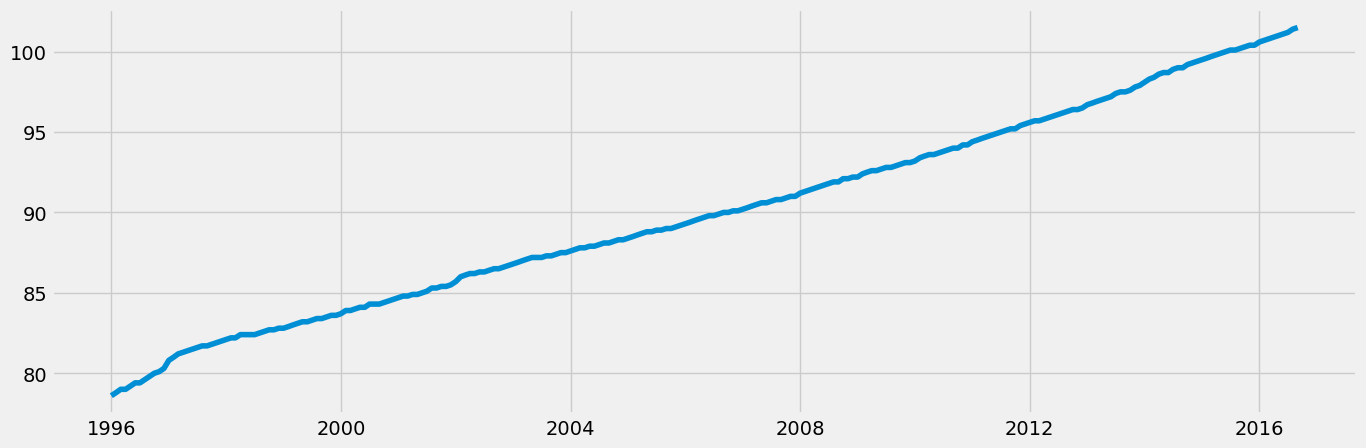

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## 02. Subsetting, wrangling and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [11]:
data_2.head()

,DATE,VALUE
0,1996-01-01,78.6
1,1996-02-01,78.8
2,1996-03-01,79.0
3,1996-04-01,79.0
4,1996-05-01,79.2


In [12]:
data_sub = data_2.loc[(data_2['DATE'] >= '1996-01-01') & (data_2['DATE'] < '2020-06-01')]

In [13]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['DATE']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['DATE'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,VALUE
datetime,
1996-01-01,78.6
1996-02-01,78.8
1996-03-01,79.0
1996-04-01,79.0
1996-05-01,79.2


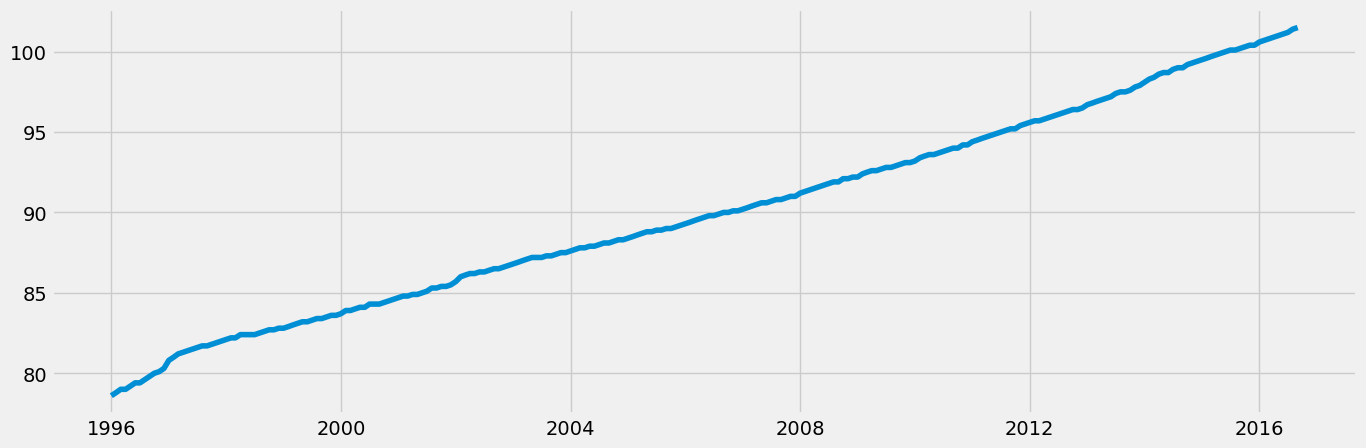

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## 03. Time-series analysis: decomposition

In [15]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

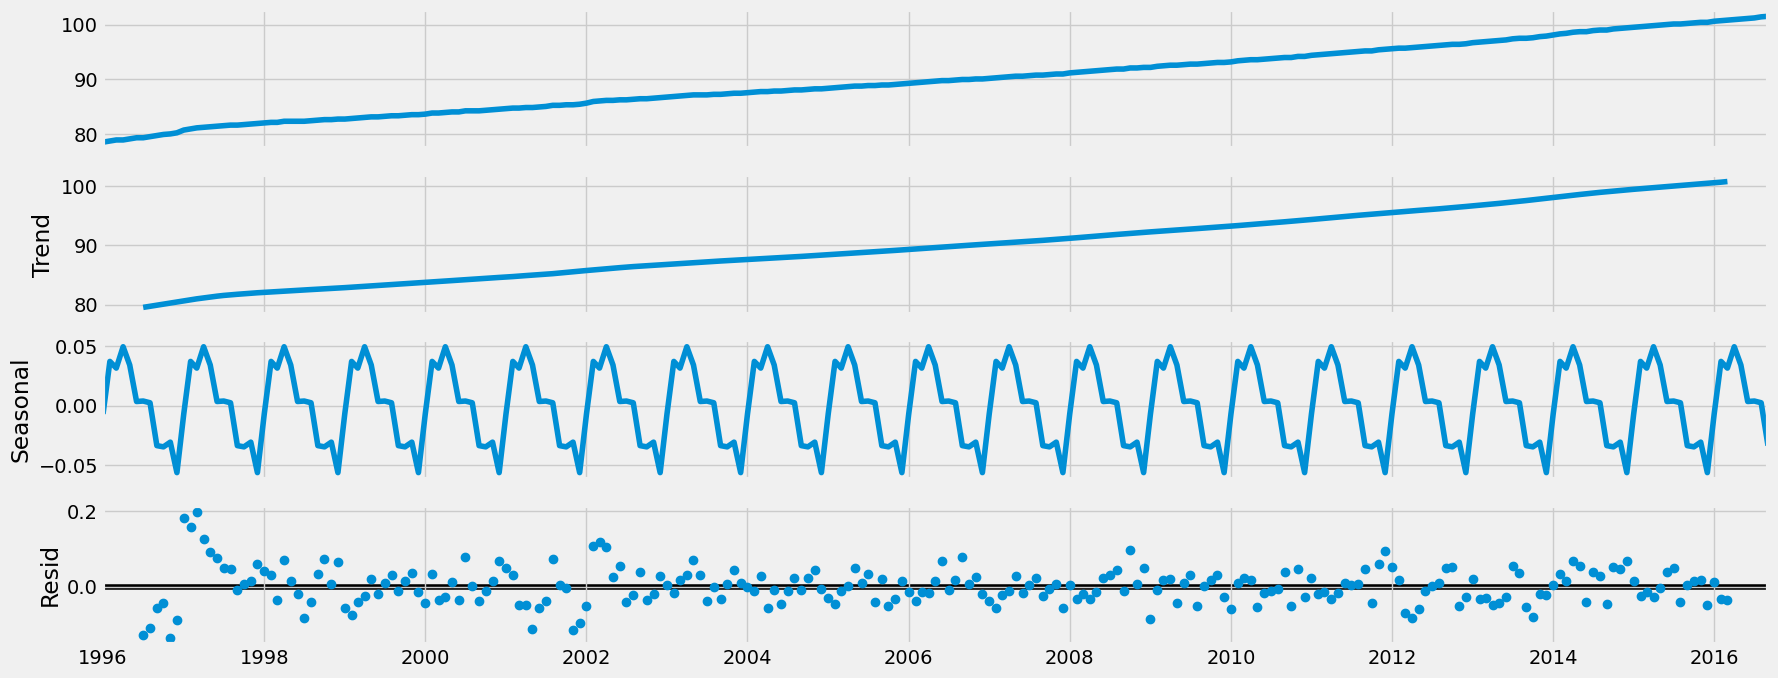

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The trend and level are nearly identical with a trend upwards meaning the prices got higher over time. Seasonality doesn't change it seems to be always the same during the same months the same reasults happen. The noice might the world cup or europa cup, because in germany it's a huge thing maybe that explains it?

## 04. Testing for stationarity

In [18]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['VALUE'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.271058
p-value                          0.975977
Number of Lags Used              1.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


#### In this case the hypotheses would be that rental prices increased over the years and have a trend to increase even more. However due to the test value being higher than the critical values we need to make it stationary so we can't reject the null hypotheses because we don't enough evidence for now.

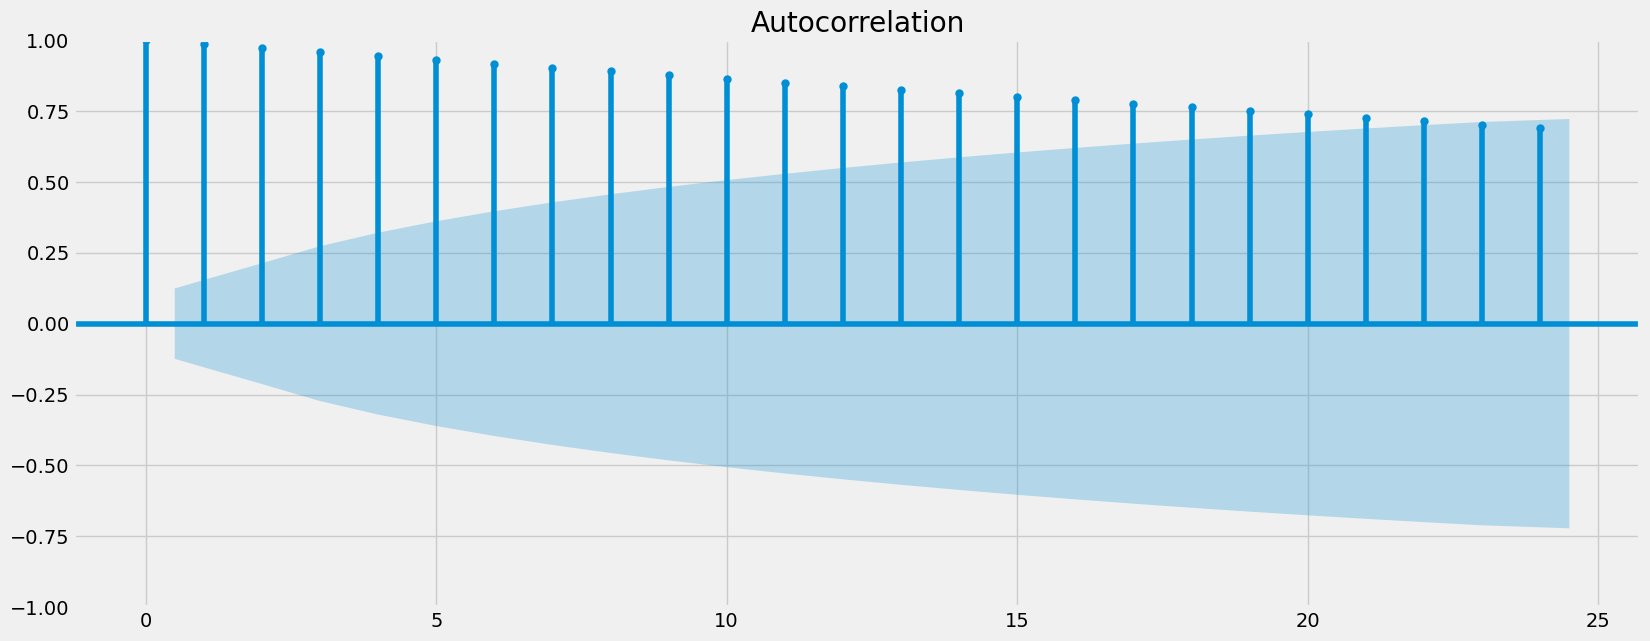

In [19]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#### We see first that there are many lags above the confidence level, which means that many of the lags are corelated with each other.

### 05. Stationarizing the Federal Reserve Economic Data

In [20]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [21]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [22]:
data_diff.head()

,VALUE
datetime,
1996-02-01,0.2
1996-03-01,0.2
1996-04-01,0.0
1996-05-01,0.2
1996-06-01,0.2


In [23]:
data_diff.columns

Index(['VALUE'], dtype='object')

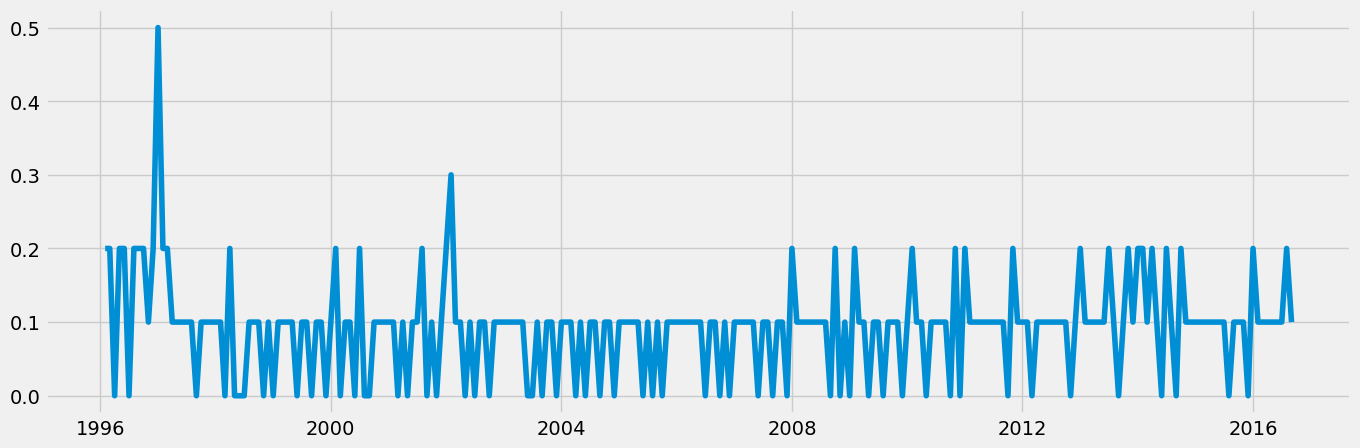

In [24]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [25]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.611345e+01
p-value                        4.984665e-29
Number of Lags Used            0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


#### Well now the test scores are much more negative than the critical values, we can fully confidentally say that it's stationary and our hypotheses is proven and we should reject the null hypotheses. Also our p value is very high showing a high confidence level in rejectin the null hypotheses. 

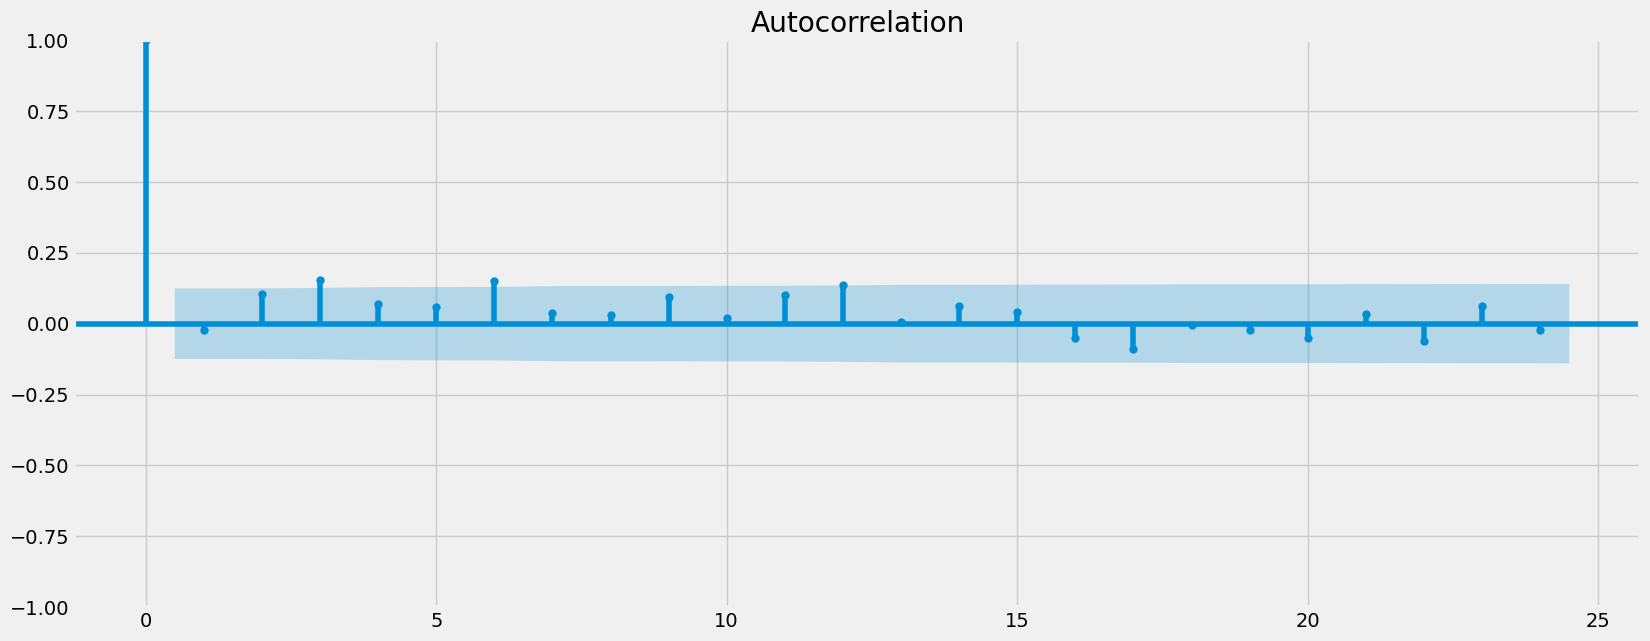

In [26]:
plot_acf(data_diff)
plt.show()

#### Besides the beginnning and here and there some outliers, the blue confidence interval is very good here, so no need to go further than this!